In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data.csv",parse_dates=["posted","scraped"])



df["age"] = (df.scraped - df.posted).dt.total_seconds()//3600
df["weekday"] = df.posted.dt.day_name()
df["weekday_number"] = df.posted.dt.dayofweek
df["hour"] = df.posted.dt.hour
df["date"] = pd.to_datetime(df.posted.dt.date)
df["year"] = df.posted.dt.year
df["month"] = df.posted.dt.month
df["yrmnth"] = (df.year-2021)*12 + df.month
df["target"] = np.log(df.upvotes+1)

df["fhost"] = df.url.apply(lambda x: "imgur" if "imgur" in x else "reddit")
df["format"] = df.url.apply(lambda x: x.split(".")[-1])

df["timestep"] = (df.posted - df.posted.min()).dt.days

sub = pd.read_csv("subscribers.csv",parse_dates=["timestamp"])

sub["date"] = sub.timestamp.dt.date

sub = sub.pivot(index="date",columns=["subreddit"],values="subscribers")

# Correcting any missing dates
daterange = pd.date_range(start=df.date.min(),end=df.date.max(),freq="D")
sub = sub.reindex(daterange)

# Filling in the new NULL values
sub.interpolate(method="linear",inplace=True)
sub.bfill(inplace=True)


# Adding the date back into the columns so we can melt the updated dataset
sub["date"] = pd.to_datetime(sub.index)
sub = pd.melt(sub,id_vars="date")


# Joining the two dataframes together
df = df.merge(sub.rename(columns={"value":"subscribers"}),how="left",on=["date","subreddit"])





stage1 = df.groupby(["date","subreddit","category","hour"],as_index=False).agg({"upvotes":"count"}).rename(columns={"upvotes":"competition_subreddit"})
stage2 = stage1.groupby(["date","hour","category"],as_index=False).agg({"competition_subreddit":"sum"}).rename(columns={"competition_subreddit":"competition_category"})
stage3 = stage2.groupby(["date","hour"],as_index=False).agg({"competition_category":"sum"}).rename(columns={"competition_category":"competition_total"})



df = df.merge(stage1,how="left",on=["date","hour","subreddit","category"]).merge(stage2,how="left",on=["date","hour","category"]).merge(stage3,how="left",on=["date","hour"])



df["title_length"] = df.title.apply(lambda x: len(x.split(" ")))
df["exclamation"] = df.title.str.contains("!")


for kw in pd.read_csv("keywords.csv").keywords:
    
    df[f'keyword_{kw}'] = df.title.str.lower().str.contains(kw)


df.head()



,fname,url,category,subreddit,title,description,upvotes,posted,scraped,niche,...,keyword_sweet,keyword_happy,keyword_big,keyword_baby,keyword_say,keyword_day,keyword_enjoy,keyword_kitten,keyword_smile,keyword_cute
0,cgptykrzcez71.jpg,https://i.redd.it/cgptykrzcez71.jpg,cats,catpictures,Caturday morning TV 😺,NaN,247.0,2021-11-13 11:22:11,2021-11-21 09:28:28.376338,0.0,...,False,False,False,False,False,True,False,False,False,False
1,EGjVMqx.jpg,https://i.imgur.com/EGjVMqx.jpg,cats,catpictures,Round loaf!,NaN,24.0,2021-11-13 02:23:31,2021-11-21 09:28:28.376338,0.0,...,False,False,False,False,False,False,False,False,False,False
2,y45936kis8z71.jpg,https://i.redd.it/y45936kis8z71.jpg,cats,catpictures,Taken over fall wreath,NaN,427.0,2021-11-12 16:38:49,2021-11-21 09:28:28.376338,0.0,...,False,False,False,False,False,False,False,False,False,False
3,irl2nzyro8z71.jpg,https://i.redd.it/irl2nzyro8z71.jpg,cats,catpictures,"My kitten, Topaz!",NaN,196.0,2021-11-12 16:17:45,2021-11-21 09:28:28.376338,0.0,...,False,False,False,False,False,False,False,True,False,False
4,vlsh4hijg8z71.jpg,https://i.redd.it/vlsh4hijg8z71.jpg,cats,catpictures,My Tom is not impressed having to wait for the...,NaN,620.0,2021-11-12 15:31:23,2021-11-21 09:28:28.376338,0.0,...,False,False,False,False,False,False,False,False,False,False


In [10]:
subjects = {"holiday":["santa","xmas","christmas","holiday","valentine","halloween","easter","thanksgiving"]
           ,"death/injury":["rip","broke her","broke his","hard time bending ","not feeling so good","not feeling well","the labs gone","splenectomy","post op","passed away","miss her","miss him","surgery","seizure","missing","hospital","hit by car","died"]
           ,"sleep":["comfy","exhausted","tuckered","yawn","relax","cozy","cuddly","chill","dreaming","lazy","bed time","bedtime","slumber","lazing","blanket","snooze","sleepy","snug ","sleep","cuddlin","tired","snoozin","loungin","snuggle","cuddle","chillin","sweepy","leisure","nappin","nap ","nap,"]
           ,"new":["new add","rescued","newest","just adopted","welcome to the fam"]
            ,"sun":["sunny","beach","enjoying morning sun","soaking up the sun","enjoying the sun","sunshine","enjoying the shade","in the sun","sunbeam","sun beam"]
           ,"snow":["snow","winter","cold","-3"]
           ,"attributes":["tail","bean","paw","face","eyes","snoot"]
           ,"playful":["game of tag","zoomies","play","fetch","tug"]
           ,"birthday":["birthday"]
#            ,"naughty":["naughty","bad girl","bad boy"]
#            ,"poses":["pose","photogenic","photoshoot"]
           ,"walk":["walk","stroll","leash","hike"]
            ,"greeting":["good morning","good evening","good night","Good murrrrning"]+[f'happy {wk.lower()}' for wk in df.weekday.unique()]
           ,"cute":["baby","babies","goodest","adorable","beautiful","cutie","cute","handsome"]
           }


def label(x):
    
    for subject,keywords in subjects.items():
        
        for kw in keywords:
            if kw in x.lower():
                return subject
            
    return "other"

df["subject"] = df.title.apply(label)

df.subject.value_counts()

other           41213
sleep            5360
cute             3423
attributes       1829
holiday          1561
snow             1018
death/injury      840
walk              727
sun               653
playful           605
birthday          567
new               345
greeting          271
Name: subject, dtype: int64

In [127]:
df.loc[df.subject=="Other","title"].sample(25).values

array(['Button and Boxer!',
       'Naked bloggers get hundreds of thousands of likes, but how many can a boy and a Pug get?',
       'My pug having major flashbacks 😆', 'comfy womfy', 'Tarzan 🧡',
       'give me attention 😠😠',
       'Long day... sweet dreams! 🌜 💤💤🐕🐶 #thechichicrew', 'Spot the Pyr!',
       'My corgi couldn’t process having an entire wiener to himself.',
       'Mamma to be 😍', 'My dog was spotted on google earth', 'Rosie',
       'Who else’s cat be claiming a whole side of the bed like mine 😵\u200d💫💀🔥😭',
       'my personal driver',
       'My heart just melted. A photo from a year ago.',
       'My boy, Campbell is five months old and 60 pounds here.',
       'Does anyone else’s dog take up this much of the bed?? We need a king lol',
       'Arya at the lake', 'Daisy just turned 2', 'Caught mid-bay',
       'Leia visiting the Peak District for the first time',
       'Recharging her solar battery', 'Just being buds',
       'Astrid enjoying her new tunnel/bed combo!

In [4]:
cat = ["category","subreddit","weekday","month","fhost","format","subject"]
num = ["niche","age","hour","year","subscribers","title_length","exclamation","timestep"] + [col for col in df.columns if "keyword" in col or "competition" in col]
target = ["target"]

In [226]:
[col for col in df.columns if col not in cat+num+target]

['fname',
 'url',
 'title',
 'description',
 'upvotes',
 'posted',
 'scraped',
 'test',
 'weekday_number',
 'date',
 'yrmnth',
 'length']

In [11]:
test = df[df.test]
train = df[~df.test]

test["target"] -= train.target.mean()
test["target"] /= train.target.std()
train["target"] -= train.target.mean()
train["target"] /= train.target.std()

C:\Users\alexi\AppData\Local\Temp/ipykernel_3964/2966662935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["target"] -= train.target.mean()
C:\Users\alexi\AppData\Local\Temp/ipykernel_3964/2966662935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["target"] /= train.target.std()
C:\Users\alexi\AppData\Local\Temp/ipykernel_3964/2966662935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [154]:
from catboost import CatBoostRegressor

In [155]:
model = CatBoostRegressor()

In [156]:
model.fit(train[cat+num],train[target],cat_features=cat)

Learning rate set to 0.075158
0:	learn: 0.9928528	total: 40.7ms	remaining: 40.7s
1:	learn: 0.9866439	total: 74.5ms	remaining: 37.2s
2:	learn: 0.9809500	total: 126ms	remaining: 41.9s
3:	learn: 0.9760163	total: 157ms	remaining: 39.1s
4:	learn: 0.9716214	total: 185ms	remaining: 36.9s
5:	learn: 0.9680207	total: 226ms	remaining: 37.5s
6:	learn: 0.9648662	total: 287ms	remaining: 40.7s
7:	learn: 0.9616295	total: 318ms	remaining: 39.4s
8:	learn: 0.9590846	total: 345ms	remaining: 38s
9:	learn: 0.9566960	total: 373ms	remaining: 36.9s
10:	learn: 0.9542792	total: 403ms	remaining: 36.2s
11:	learn: 0.9520360	total: 434ms	remaining: 35.8s
12:	learn: 0.9504072	total: 464ms	remaining: 35.2s
13:	learn: 0.9488354	total: 516ms	remaining: 36.4s
14:	learn: 0.9471785	total: 548ms	remaining: 36s
15:	learn: 0.9461389	total: 575ms	remaining: 35.4s
16:	learn: 0.9447009	total: 605ms	remaining: 35s
17:	learn: 0.9433621	total: 638ms	remaining: 34.8s
18:	learn: 0.9421541	total: 677ms	remaining: 35s
19:	learn: 0.9410

163:	learn: 0.9069299	total: 7.26s	remaining: 37s
164:	learn: 0.9068301	total: 7.3s	remaining: 36.9s
165:	learn: 0.9067617	total: 7.34s	remaining: 36.9s
166:	learn: 0.9066249	total: 7.37s	remaining: 36.8s
167:	learn: 0.9064643	total: 7.42s	remaining: 36.7s
168:	learn: 0.9062989	total: 7.45s	remaining: 36.6s
169:	learn: 0.9061289	total: 7.53s	remaining: 36.8s
170:	learn: 0.9059525	total: 7.58s	remaining: 36.8s
171:	learn: 0.9058401	total: 7.72s	remaining: 37.2s
172:	learn: 0.9056328	total: 7.75s	remaining: 37.1s
173:	learn: 0.9055781	total: 7.86s	remaining: 37.3s
174:	learn: 0.9055156	total: 7.91s	remaining: 37.3s
175:	learn: 0.9054289	total: 7.95s	remaining: 37.2s
176:	learn: 0.9053134	total: 7.98s	remaining: 37.1s
177:	learn: 0.9052445	total: 8.09s	remaining: 37.4s
178:	learn: 0.9052339	total: 8.11s	remaining: 37.2s
179:	learn: 0.9051650	total: 8.15s	remaining: 37.1s
180:	learn: 0.9050693	total: 8.18s	remaining: 37s
181:	learn: 0.9049556	total: 8.32s	remaining: 37.4s
182:	learn: 0.904

322:	learn: 0.8931938	total: 15.2s	remaining: 31.8s
323:	learn: 0.8930551	total: 15.2s	remaining: 31.7s
324:	learn: 0.8930381	total: 15.2s	remaining: 31.6s
325:	learn: 0.8930202	total: 15.3s	remaining: 31.6s
326:	learn: 0.8929212	total: 15.3s	remaining: 31.5s
327:	learn: 0.8928270	total: 15.3s	remaining: 31.4s
328:	learn: 0.8927527	total: 15.4s	remaining: 31.4s
329:	learn: 0.8927008	total: 15.4s	remaining: 31.3s
330:	learn: 0.8926916	total: 15.5s	remaining: 31.2s
331:	learn: 0.8926498	total: 15.5s	remaining: 31.2s
332:	learn: 0.8925444	total: 15.5s	remaining: 31.1s
333:	learn: 0.8924042	total: 15.6s	remaining: 31.1s
334:	learn: 0.8923686	total: 15.7s	remaining: 31.1s
335:	learn: 0.8922361	total: 15.8s	remaining: 31.2s
336:	learn: 0.8921296	total: 15.8s	remaining: 31.1s
337:	learn: 0.8920623	total: 15.8s	remaining: 31s
338:	learn: 0.8919877	total: 15.9s	remaining: 31s
339:	learn: 0.8919491	total: 16s	remaining: 31s
340:	learn: 0.8918475	total: 16s	remaining: 30.9s
341:	learn: 0.8917520	

482:	learn: 0.8826601	total: 22.8s	remaining: 24.4s
483:	learn: 0.8825836	total: 22.9s	remaining: 24.4s
484:	learn: 0.8825300	total: 22.9s	remaining: 24.3s
485:	learn: 0.8824308	total: 23s	remaining: 24.3s
486:	learn: 0.8823886	total: 23s	remaining: 24.2s
487:	learn: 0.8823469	total: 23.1s	remaining: 24.2s
488:	learn: 0.8822545	total: 23.2s	remaining: 24.2s
489:	learn: 0.8821804	total: 23.2s	remaining: 24.2s
490:	learn: 0.8820694	total: 23.3s	remaining: 24.1s
491:	learn: 0.8819814	total: 23.3s	remaining: 24.1s
492:	learn: 0.8819050	total: 23.4s	remaining: 24s
493:	learn: 0.8818409	total: 23.4s	remaining: 24s
494:	learn: 0.8818168	total: 23.5s	remaining: 23.9s
495:	learn: 0.8817080	total: 23.5s	remaining: 23.9s
496:	learn: 0.8816393	total: 23.5s	remaining: 23.8s
497:	learn: 0.8815407	total: 23.6s	remaining: 23.8s
498:	learn: 0.8814598	total: 23.6s	remaining: 23.7s
499:	learn: 0.8813616	total: 23.6s	remaining: 23.6s
500:	learn: 0.8812810	total: 23.7s	remaining: 23.6s
501:	learn: 0.881196

642:	learn: 0.8737424	total: 30.4s	remaining: 16.9s
643:	learn: 0.8736993	total: 30.4s	remaining: 16.8s
644:	learn: 0.8736719	total: 30.4s	remaining: 16.7s
645:	learn: 0.8735660	total: 30.5s	remaining: 16.7s
646:	learn: 0.8734870	total: 30.5s	remaining: 16.6s
647:	learn: 0.8734567	total: 30.6s	remaining: 16.6s
648:	learn: 0.8734151	total: 30.6s	remaining: 16.6s
649:	learn: 0.8733547	total: 30.7s	remaining: 16.5s
650:	learn: 0.8733260	total: 30.7s	remaining: 16.5s
651:	learn: 0.8732693	total: 30.8s	remaining: 16.4s
652:	learn: 0.8732273	total: 30.8s	remaining: 16.4s
653:	learn: 0.8731383	total: 30.9s	remaining: 16.3s
654:	learn: 0.8730421	total: 30.9s	remaining: 16.3s
655:	learn: 0.8729867	total: 30.9s	remaining: 16.2s
656:	learn: 0.8729647	total: 30.9s	remaining: 16.2s
657:	learn: 0.8729118	total: 31s	remaining: 16.1s
658:	learn: 0.8728467	total: 31s	remaining: 16.1s
659:	learn: 0.8728149	total: 31.1s	remaining: 16s
660:	learn: 0.8727815	total: 31.1s	remaining: 16s
661:	learn: 0.872722

801:	learn: 0.8657997	total: 37.9s	remaining: 9.36s
802:	learn: 0.8657839	total: 37.9s	remaining: 9.31s
803:	learn: 0.8657084	total: 38s	remaining: 9.26s
804:	learn: 0.8655879	total: 38.1s	remaining: 9.23s
805:	learn: 0.8654760	total: 38.1s	remaining: 9.18s
806:	learn: 0.8654210	total: 38.3s	remaining: 9.15s
807:	learn: 0.8654111	total: 38.3s	remaining: 9.1s
808:	learn: 0.8653990	total: 38.3s	remaining: 9.05s
809:	learn: 0.8652921	total: 38.4s	remaining: 9.02s
810:	learn: 0.8652657	total: 38.5s	remaining: 8.97s
811:	learn: 0.8652328	total: 38.6s	remaining: 8.93s
812:	learn: 0.8651424	total: 38.6s	remaining: 8.88s
813:	learn: 0.8650781	total: 38.7s	remaining: 8.83s
814:	learn: 0.8649783	total: 38.8s	remaining: 8.8s
815:	learn: 0.8649659	total: 38.9s	remaining: 8.76s
816:	learn: 0.8649119	total: 38.9s	remaining: 8.71s
817:	learn: 0.8648147	total: 39s	remaining: 8.68s
818:	learn: 0.8647190	total: 39.1s	remaining: 8.64s
819:	learn: 0.8646501	total: 39.1s	remaining: 8.59s
820:	learn: 0.8646

964:	learn: 0.8575263	total: 46.3s	remaining: 1.68s
965:	learn: 0.8574364	total: 46.3s	remaining: 1.63s
966:	learn: 0.8574194	total: 46.4s	remaining: 1.58s
967:	learn: 0.8574095	total: 46.4s	remaining: 1.53s
968:	learn: 0.8573759	total: 46.5s	remaining: 1.49s
969:	learn: 0.8573314	total: 46.5s	remaining: 1.44s
970:	learn: 0.8572966	total: 46.6s	remaining: 1.39s
971:	learn: 0.8572480	total: 46.7s	remaining: 1.34s
972:	learn: 0.8572384	total: 46.7s	remaining: 1.29s
973:	learn: 0.8572086	total: 46.7s	remaining: 1.25s
974:	learn: 0.8571894	total: 46.8s	remaining: 1.2s
975:	learn: 0.8571416	total: 46.8s	remaining: 1.15s
976:	learn: 0.8571066	total: 46.9s	remaining: 1.1s
977:	learn: 0.8570958	total: 46.9s	remaining: 1.05s
978:	learn: 0.8569927	total: 47s	remaining: 1.01s
979:	learn: 0.8569019	total: 47.1s	remaining: 961ms
980:	learn: 0.8568533	total: 47.1s	remaining: 912ms
981:	learn: 0.8567453	total: 47.1s	remaining: 864ms
982:	learn: 0.8567404	total: 47.2s	remaining: 816ms
983:	learn: 0.85

In [157]:
pred = model.predict(test[cat+num])

In [158]:
from sklearn.metrics import mean_squared_error as mse

In [159]:
mse(pred,test.target,squared=False)

0.9107004600275057

In [160]:
test["pred"] = pred

C:\Users\alexi\AppData\Local\Temp/ipykernel_16172/1330184522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["pred"] = pred


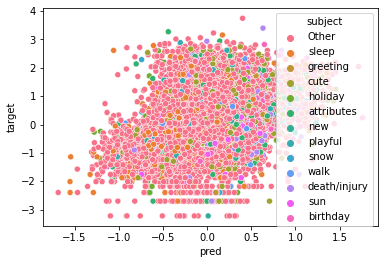

In [161]:
sns.scatterplot(data=test,x="pred",y="target",hue="subject");

In [162]:
fi = pd.DataFrame({"column":cat+num,"importance":model.feature_importances_})

fi

,column,importance
0,category,0.876936
1,subreddit,21.104682
2,weekday,1.102077
3,month,3.736704
4,fhost,0.834229
...,...,...
75,keyword_day,0.556626
76,keyword_enjoy,0.074200
77,keyword_kitten,0.227174
78,keyword_smile,0.284772


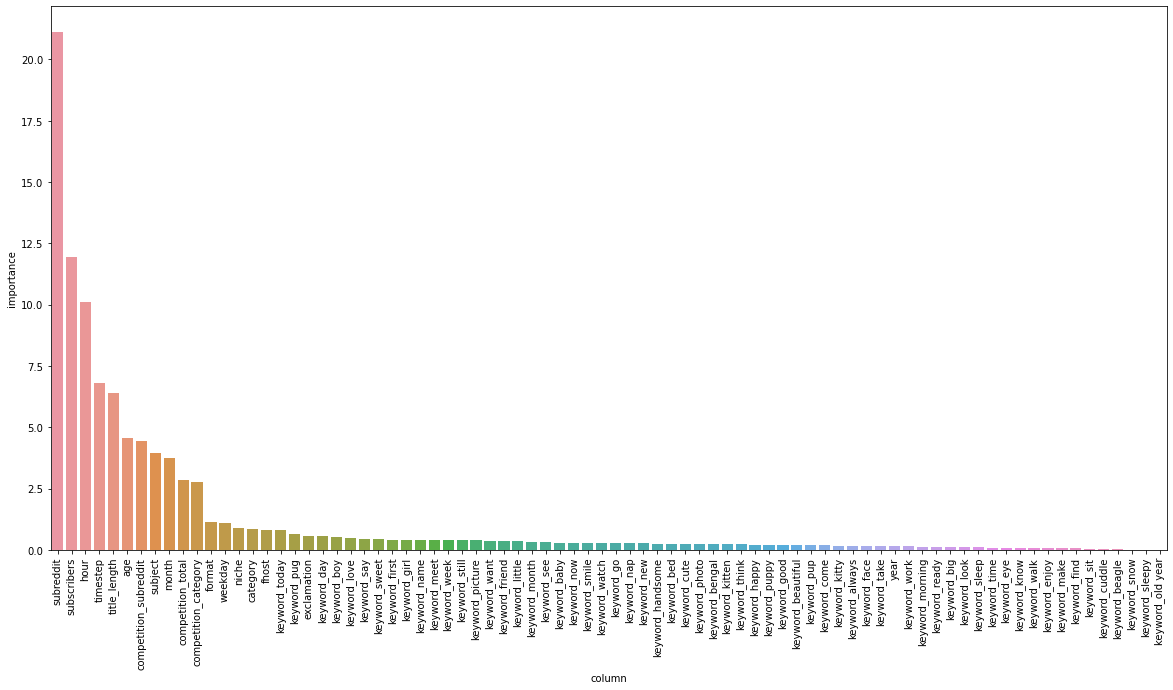

In [164]:
fig,ax = plt.subplots(figsize=(20,10))

sns.barplot(data=fi.sort_values("importance",ascending=False),x="column",y="importance")

plt.xticks(rotation = 90);

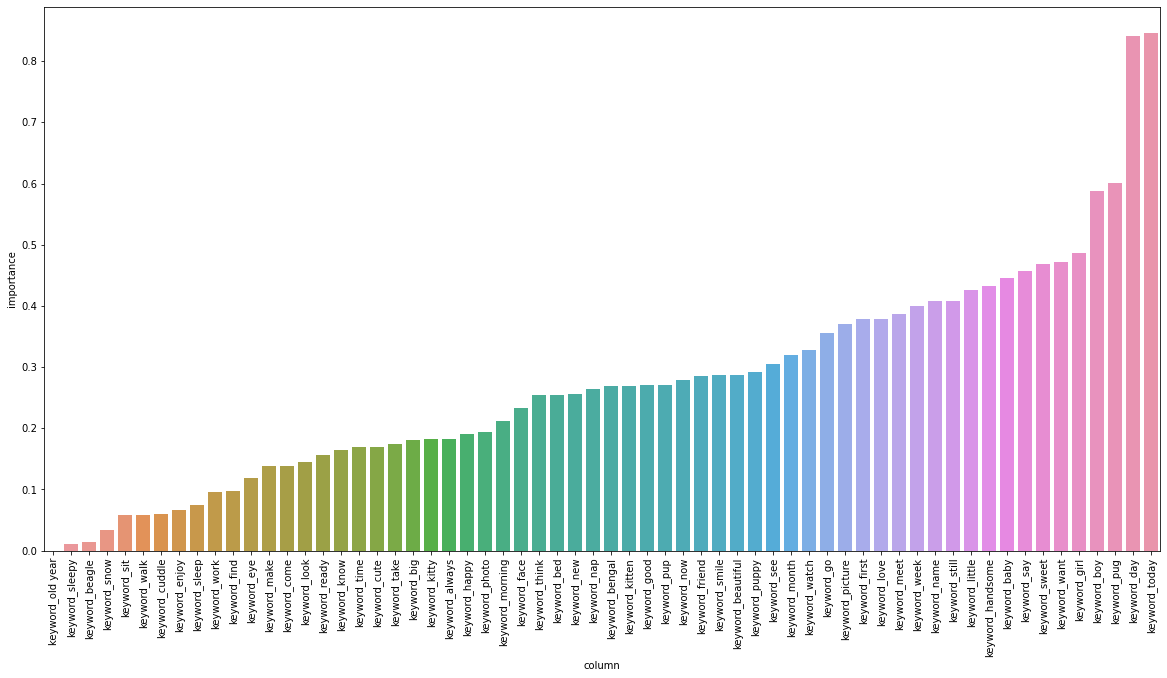

In [32]:
fig,ax = plt.subplots(figsize=(20,10))

sns.barplot(data=fi[fi.column.str.contains("keyword")].sort_values("importance"),x="column",y="importance")

plt.xticks(rotation = 90);

In [34]:
df[df.keyword_today|df.keyword_day].title

0                                    Caturday morning TV 😺
6                            My cat Squeeki. Happy Friday!
33                                           happy Tuesday
45       Yesterday posted a picture of our office cat C...
49       On this day two years ago (7th Nov), I adopted...
                               ...                        
58319    Tiffany - my little fighter. Went in to the ER...
58325    Happy Birthday Buddy, 10 years old today :) Ha...
58347    Hi! I’m wondering at what age your pug needed ...
58387                  She just turned 1 a couple days ago
58407    missing them a lot today </3 (context is i’m a...
Name: title, Length: 5514, dtype: object

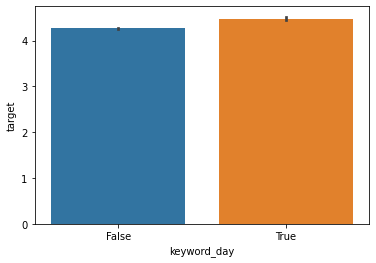

In [36]:
sns.barplot(data=df,x="keyword_day",y="target");

In [39]:
df.title.str.lower().str.contains("birthday").mean()

0.010374580565637198

In [190]:
df["length"] = df["title_length"].astype(str)

In [191]:
df.loc[(df.title_length>=10)&(df.title_length<15),"length"] = "10-14"

In [192]:
df.loc[(df.title_length>=15)&(df.title_length<20),"length"] = "15-19"

In [193]:
df.loc[(df.title_length>=20)&(df.title_length<25),"length"] = "20-24"

In [194]:
df.loc[(df.title_length>=25)&(df.title_length<30),"length"] = "25-29"

In [195]:
df.loc[(df.title_length>=30),"length"] = ">=30"

In [196]:
df.length.value_counts()

10-14    8876
4        6238
3        5910
5        5766
6        5166
2        5018
7        4378
15-19    3969
8        3649
9        2973
1        2155
20-24    1780
>=30     1577
25-29     957
Name: length, dtype: int64

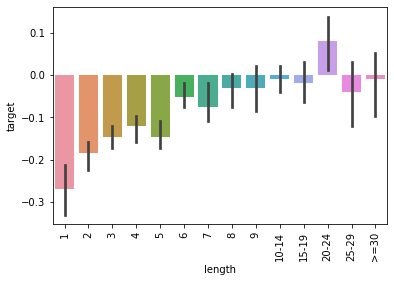

In [205]:
sns.barplot(data=train,x="length",y="target",estimator=np.median,order=[str(i) for i in range(1,10)]+[f'{5*i + 10}-{5*i + 14}' for i in range(4)] + [">=30"])

plt.xticks(rotation = 90);

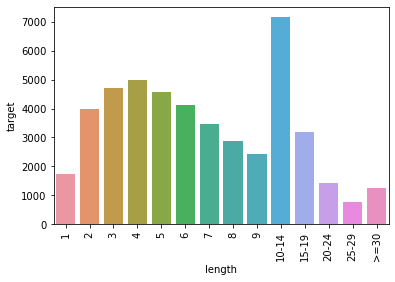

In [208]:
sns.barplot(data=train,x="length",y="target",estimator=len,order=[str(i) for i in range(1,10)]+[f'{5*i + 10}-{5*i + 14}' for i in range(4)] + [">=30"])

plt.xticks(rotation = 90);

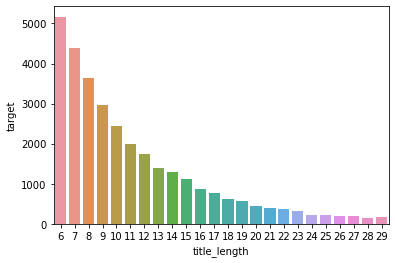

In [211]:
sns.barplot(data=df[(df.title_length>5)&(df.title_length<30)],x="title_length",y="target",estimator=len);

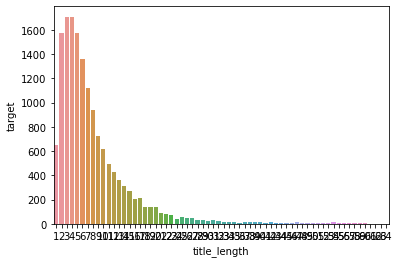

In [168]:
sns.barplot(data=df[df.category=="cats"],x="title_length",y="target",estimator=len);

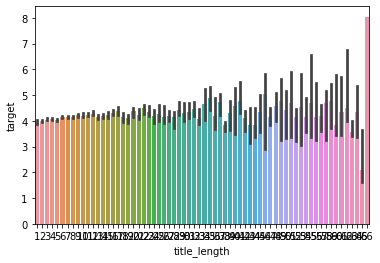

In [176]:
sns.barplot(data=df[df.category=="dogs"],x="title_length",y="target",estimator=np.median);

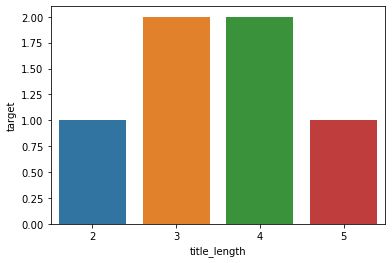

In [172]:
sns.barplot(data=df[df.subreddit=="YorkshireTerrier"],x="title_length",y="target",estimator=len);

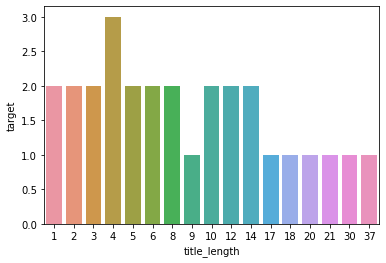

In [175]:
sns.barplot(data=df[df.subreddit=="BombayCat"],x="title_length",y="target",estimator=len);

In [174]:
df.groupby(["subreddit"],as_index=False).agg({"title_length":"median"}).sort_values("title_length")

,subreddit,title_length
31,birmans,3.0
25,YorkshireTerrier,3.5
44,pomeranian,4.0
12,MiniatureSchnauzer,4.0
45,pug,5.0
39,graycats,5.0
36,egyptianmau,5.0
33,britishshorthair,5.0
27,bassethounds,5.0
24,WhiteCats,5.0


In [219]:
pd.set_option('display.max_rows', None)

In [222]:
df.columns

Index(['fname', 'url', 'category', 'subreddit', 'title', 'description',
       'upvotes', 'posted', 'scraped', 'niche', 'test', 'age', 'weekday',
       'weekday_number', 'hour', 'date', 'year', 'month', 'yrmnth', 'target',
       'fhost', 'format', 'timestep', 'subscribers', 'competition_subreddit',
       'competition_category', 'competition_total', 'title_length',
       'exclamation', 'keyword_make', 'keyword_always', 'keyword_look',
       'keyword_find', 'keyword_month', 'keyword_morning', 'keyword_sit',
       'keyword_sleep', 'keyword_bed', 'keyword_ready', 'keyword_good',
       'keyword_beagle', 'keyword_still', 'keyword_handsome', 'keyword_love',
       'keyword_first', 'keyword_friend', 'keyword_work', 'keyword_snow',
       'keyword_nap', 'keyword_see', 'keyword_take', 'keyword_week',
       'keyword_boy', 'keyword_name', 'keyword_beautiful', 'keyword_puppy',
       'keyword_pug', 'keyword_cuddle', 'keyword_pup', 'keyword_new',
       'keyword_eye', 'keyword_go', 'keyword_

In [220]:
df[["target"]+[col for col in df.columns if "keyword" in col]].corr()["target"].sort_values()

keyword_sleep       -0.020572
keyword_sleepy      -0.018269
keyword_nap         -0.016915
keyword_watch       -0.015237
keyword_bed         -0.008477
keyword_find        -0.008215
keyword_pup         -0.007978
keyword_snow        -0.007089
keyword_kitty       -0.003002
keyword_time        -0.002726
keyword_see         -0.002008
keyword_know        -0.001929
keyword_cute        -0.001779
keyword_cuddle      -0.001527
keyword_big         -0.001092
keyword_work        -0.001083
keyword_eye         -0.000243
keyword_old year    -0.000164
keyword_enjoy       -0.000117
keyword_think        0.001550
keyword_picture      0.001586
keyword_now          0.001851
keyword_walk         0.003844
keyword_make         0.004083
keyword_puppy        0.004732
keyword_sit          0.005532
keyword_always       0.006620
keyword_name         0.006735
keyword_ready        0.006863
keyword_look         0.007023
keyword_kitten       0.007157
keyword_month        0.007798
keyword_friend       0.007931
keyword_ta

In [13]:
label_order = sorted(train.subject.unique().tolist())

In [18]:
(df.subject=="other").mean()

0.7055570773128809

<AxesSubplot:xlabel='subject', ylabel='target'>

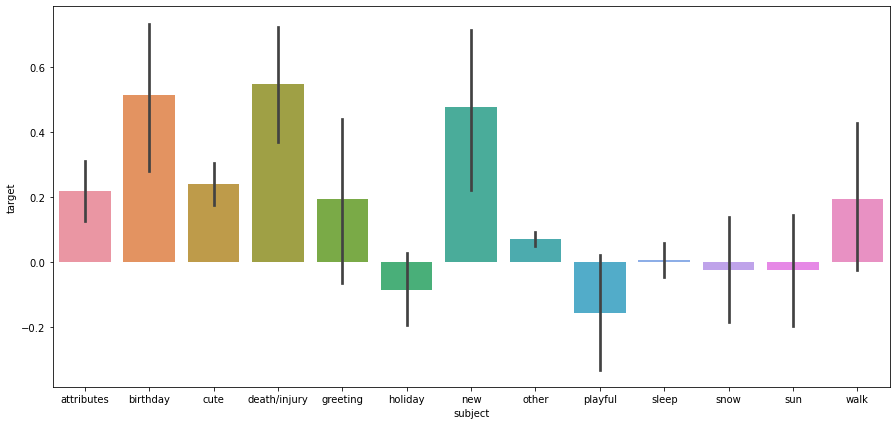

In [16]:
fig,ax = plt.subplots(figsize=(15,7))
sns.barplot(data=train[train.category=="cats"],x="subject",y="target",order=label_order)

<AxesSubplot:xlabel='subject', ylabel='target'>

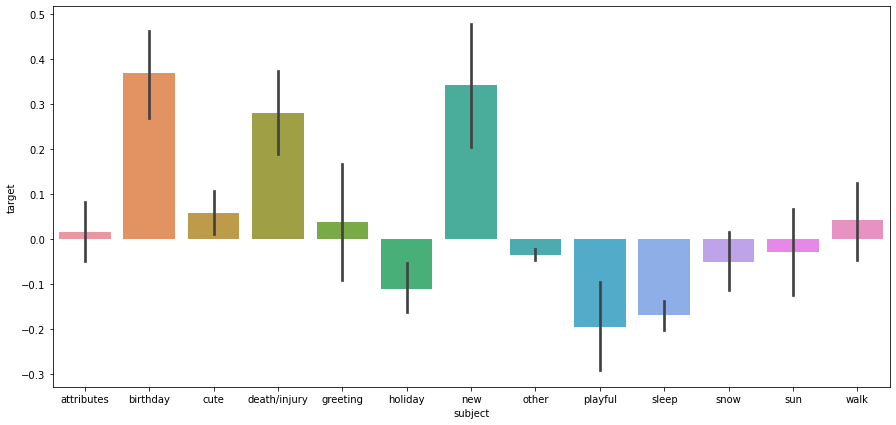

In [14]:
fig,ax = plt.subplots(figsize=(15,7))
sns.barplot(data=train[train.category=="dogs"],x="subject",y="target",order=label_order)

<AxesSubplot:xlabel='subject', ylabel='target'>

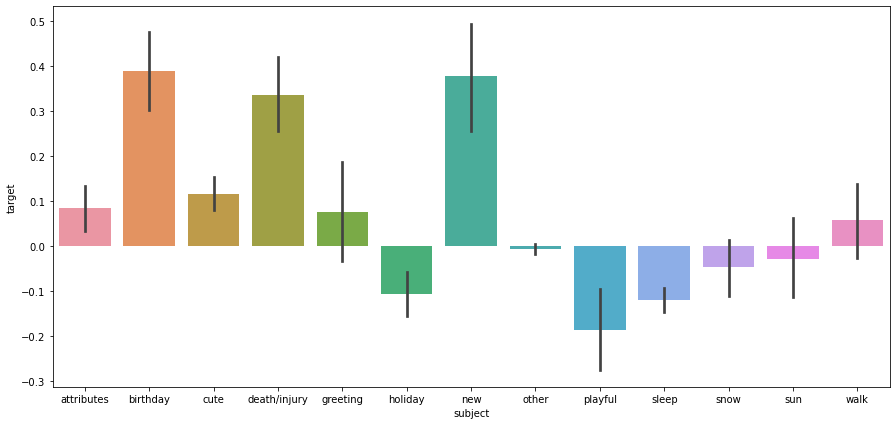

In [15]:
fig,ax = plt.subplots(figsize=(15,7))
sns.barplot(data=train,x="subject",y="target",order=label_order)

<AxesSubplot:xlabel='subject', ylabel='target'>

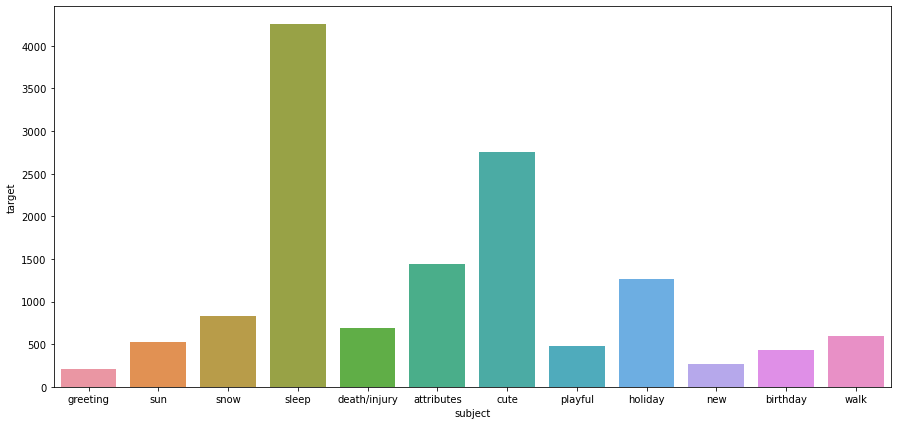

In [234]:
fig,ax = plt.subplots(figsize=(15,7))
sns.barplot(data=train[train.subject!="Other"],estimator=len,x="subject",y="target")

<AxesSubplot:xlabel='hour', ylabel='target'>

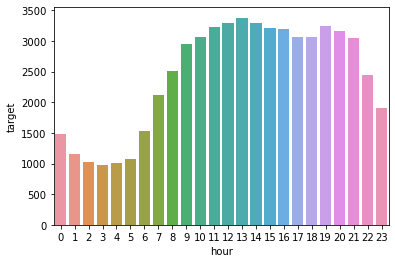

In [235]:
sns.barplot(data=df,x="hour",y="target",estimator=len)

<AxesSubplot:xlabel='hour', ylabel='target'>

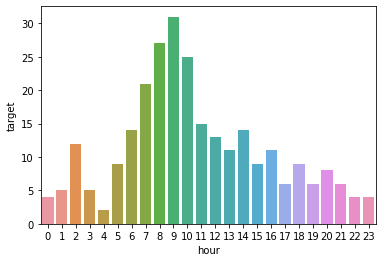

In [236]:
sns.barplot(data=df[df.subject=="greeting"],x="hour",y="target",estimator=len)

<AxesSubplot:xlabel='hour', ylabel='target'>

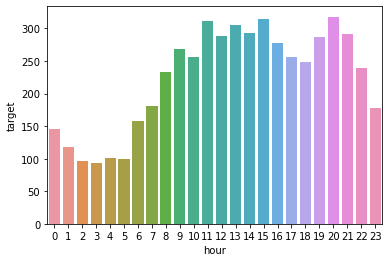

In [237]:
sns.barplot(data=df[df.subject=="sleep"],x="hour",y="target",estimator=len)

<AxesSubplot:xlabel='hour', ylabel='target'>

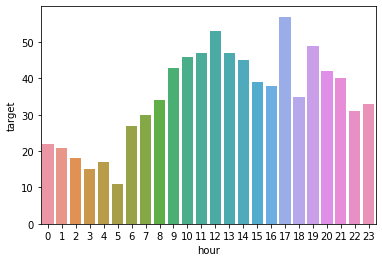

In [238]:
sns.barplot(data=df[df.subject=="death/injury"],x="hour",y="target",estimator=len)

In [241]:
df.loc[df.subject=="birthday","title"].sample(15).values

array(['Valens first birthday 🎂🥳',
       "It's Jolene's first birthday today, and of course it's pouring rain at the campground",
       'Happy 4th Birthday Fen!',
       "When it's ur bestfriends birthday and ur hyping him up during his photoshoot :-)",
       "Today was Tootie's 1st Birthday. She was a HAPPY puppy!",
       'Happy 1st birthday! 🎉', 'happy birthday',
       'My Birthday Boy - Turned 1 today!',
       'Our little rescue Cookie celebrating her 1st birthday.',
       'Happy Birthday Luci-FUR!',
       'Today is Peppa’s 4th birthday! She’s our little one-eyed bork machine and we love her to pieces 🥰',
       'My pup loves cookies! It’s his birthday month. Can’t believe he is turning 9.',
       'It was his birthday today so he got to eat at the table with us',
       'I had a pot painted of our dog for my partner’s birthday',
       'It’s my girls Gotcha Day! A year ago, I never thought I’d adopt a pittie but it’s the best decision I ever made! Sweetest and gentlest girl